In [19]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.datasets import make_classification

In [21]:
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.datasets import make_imbalance

In [22]:
def measures(estimator, X, y):
    y_predicted = estimator.predict(X)
    true_positive = (y_predicted == 1)[y == 1].sum()
    false_positive = (y_predicted == 1)[y == 0].sum()
    true_negative = (y_predicted == 0)[y == 0].sum()
    false_negative = (y_predicted == 0)[y == 1].sum()
    return true_positive, false_positive, true_negative, false_negative

In [23]:
def F_measure(estimator, X, y):
    true_positive, false_positive, true_negative, false_negative = measures(estimator, X, y)
    return 2 * true_positive / (2 * true_positive + false_positive + false_negative)

In [24]:
def G_mean(estimator, X, y):
    true_positive, false_positive, true_negative, false_negative = measures(estimator, X, y)
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)
    return sqrt(sensitivity * specificity)

In [25]:
datasets_parameters = [{"n_classes": 2, "class_sep": 2, "n_clusters_per_class": 1, "weights": [0.95, 0.05], "n_samples": 500, "n_features": 2, "n_redundant": 0, "n_repeated": 0, "random_state": 5}, 
                      {"n_classes": 2, "class_sep": 2, "n_clusters_per_class": 2, "weights": [0.90, 0.10], "n_samples": 1000, "n_features": 2, "n_redundant": 0, "n_repeated": 0, "random_state": 5},
                      {"n_classes": 2, "class_sep": 2, "n_clusters_per_class": 1, "weights": [0.85, 0.15], "n_samples": 1500, "n_features": 2, "n_redundant": 0, "n_repeated": 0, "random_state": 5},
                      {"n_classes": 2, "class_sep": 2, "n_clusters_per_class": 2, "weights": [0.85, 0.15], "n_samples": 2000, "n_features": 2, "n_redundant": 0, "n_repeated": 0, "random_state": 5}]

In [26]:
imbalanced_datasets = []
for parameters in datasets_parameters:
    imbalanced_datasets.append(make_classification(**parameters))

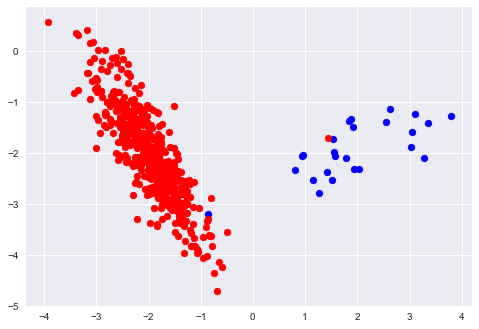

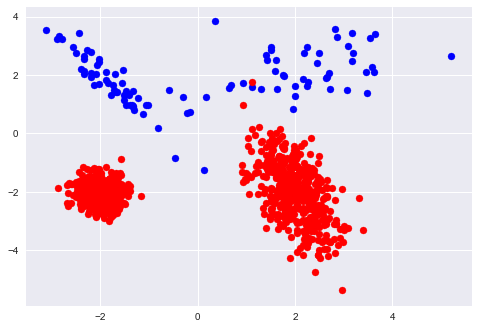

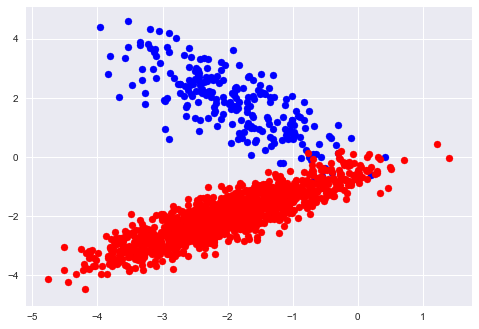

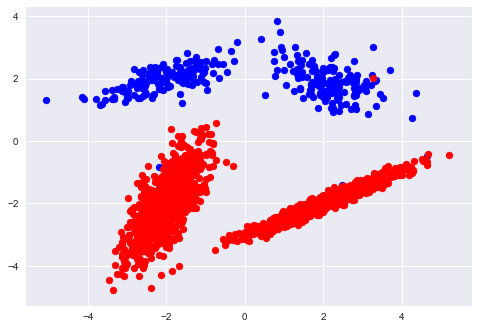

In [27]:
sns.set()
for imbalanced_dataset in imbalanced_datasets:
    X, y = imbalanced_dataset
    minority_indices = (y == 1)
    p = plt.scatter(X[minority_indices, 0], X[minority_indices, 1], color="blue")
    p = plt.scatter(X[~minority_indices, 0], X[~minority_indices, 1], color="red")
    plt.show()

In [28]:
datasets_description = pd.DataFrame({}, columns=["# of features", "# of instances", "# of minority instances", "# of majority instances", "Imbalanced Ratio"])
for ind, (X, y) in enumerate(imbalanced_datasets):
    num_features = X.shape[1]
    num_instances = y.size
    num_minority_instances = (y == 1).sum()
    num_majority_instances = (y == 0).sum()
    IR = round((y == 0).sum() / (y == 1).sum(), 2)
    datasets_description.loc[len(datasets_description)] = [num_features, num_instances, num_minority_instances, num_majority_instances, IR]
data_types = ["object", "object", "int64", "int64", "int64", "int64", "float64"]
for ind, feature in enumerate(datasets_description.columns):
    datasets_description[feature] = datasets_description[feature].astype(data_types[ind])
datasets_description

,# of features,# of instances,# of minority instances,# of majority instances,Imbalanced Ratio
0,2,500,25,475,19
1,2,1000,102,898,8
2,2,1500,232,1268,5
3,2,2000,305,1695,5


In [29]:
cv_scores = []
metrics = ['roc_auc', F_measure, G_mean]
random_states = [5 * i for i in range(5)]


In [30]:
for random_state in random_states:
    cv = StratifiedKFold(n_splits=5, random_state=random_state)
    algorithms = [LogisticRegression(random_state=random_state)]
    methods = [None, RandomOverSampler(random_state=random_state), SMOTE(random_state=random_state, k_neighbors=3), SMOTE(random_state=random_state, kind='borderline1', k_neighbors=3), ADASYN(random_state=random_state, n_neighbors=3), SMOTEENN(random_state=random_state), SMOTETomek(random_state=random_state)]
    for algorithm in algorithms:
        for ind, (X, y) in enumerate(imbalanced_datasets):
            for method in methods:
                for metric in metrics:
                    if method is None:
                        clf = algorithm
                    else:
                        clf = make_pipeline(method, algorithm)
                    cv_scores.append(cross_val_score(clf, X, y, cv=cv, scoring=metric).mean())

In [31]:
algorithms_names = ["LR"]
datasets_names = ["two_dim_data1", "two_dim_data2"]
metrics_names = ["AUC", "F", "G"]
methods_names = ["None", "Random", "SMOTE", "Borderline SMOTE", "ADASYN", "SMOTEENN","SMOTETomek"]

In [32]:
mean_cv_scores = np.array(cv_scores).reshape(len(random_states), -1).mean(axis=0).reshape(len(algorithms), len(imbalanced_datasets), len(methods), len(metrics))
mean_results = pd.DataFrame()
for ind1, alg_name in enumerate(algorithms_names):
    for ind2, ds_name in enumerate(datasets_names):
        partial_results = pd.DataFrame(mean_cv_scores[ind1, ind2, :, :].transpose(), columns=methods_names)
        partial_results.insert(0, "Metric", metrics_names)
        partial_results.insert(0, "Dataset", ds_name)
        partial_results.insert(0, "Algorithm", alg_name)
        mean_results = pd.concat([mean_results, partial_results])
mean_results = mean_results.reset_index(drop=True)

In [33]:
std_cv_scores = np.array(cv_scores).reshape(len(random_states), -1).std(axis=0).reshape(len(algorithms), len(imbalanced_datasets), len(methods), len(metrics))
std_results = pd.DataFrame()
for ind1, alg_name in enumerate(algorithms_names):
    for ind2, ds_name in enumerate(datasets_names):
        partial_results = pd.DataFrame(std_cv_scores[ind1, ind2, :, :].transpose(), columns=methods_names)
        partial_results.insert(0, "Metric", metrics_names)
        partial_results.insert(0, "Dataset", ds_name)
        partial_results.insert(0, "Algorithm", alg_name)
        std_results = pd.concat([std_results, partial_results])
std_results = std_results.reset_index(drop=True)

In [34]:

ranking = mean_results.apply(lambda row: len(row[3:]) - row[3:].argsort().argsort(), axis=1)
aggregated_ranking = round(pd.concat([mean_results[["Algorithm", "Metric"]], ranking], axis=1).groupby(["Algorithm", "Metric"]).mean(), 2)
aggregated_ranking

None  Random  SMOTE  Borderline SMOTE  ADASYN  SMOTEENN  \
Algorithm Metric                                                            
LR        AUC      4.0     5.0    3.5               4.5     5.0       4.0   
          F        2.5     5.0    4.0               4.5     7.0       3.5   
          G        2.5     5.0    3.5               4.5     7.0       3.5   

                  SMOTETomek  
Algorithm Metric              
LR        AUC            2.0  
          F              1.5  
          G              2.0

In [35]:
friedman_results = pd.DataFrame({}, columns=["Algorithm", "Metric", "p-value"])
for alg_name in algorithms_names:
    for metric_name in metrics_names:
        partial_ranking = pd.concat([mean_results[["Algorithm", "Metric"]], ranking], axis=1)[(mean_results["Algorithm"] == alg_name) & (mean_results["Metric"] == metric_name)]
        friedman_inputs = []
        for method_name in methods_names:
            friedman_inputs.append(partial_ranking[method_name])
        pvalue = round(scipy.stats.friedmanchisquare(*friedman_inputs).pvalue, 2)
        friedman_results.loc[len(friedman_results)] = [alg_name, metric_name, pvalue]
friedman_results

,Algorithm,Metric,p-value
0,LR,AUC,0.84
1,LR,F,0.23
2,LR,G,0.30
